In [1]:
!pip3 install scikit-learn tqdm catboost optuna xgboost ipywidgets imblearn
# 모델을 위해 필요한 라이브러리 설치(우수 예시에만 있는 부분)

In [2]:
import pandas as pd
import sklearn
import numpy as np
import random
import os
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
import optuna
from optuna.samplers import TPESampler
from optuna.pruners import SuccessiveHalvingPruner
from catboost import CatBoostClassifier, Pool

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import RobustScaler

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed=42
seed_everything(seed) # Seed 고정

In [4]:
df_train = pd.read_csv("train.csv") # 학습용 데이터
df_test = pd.read_csv("submission.csv") # 테스트 데이터(제출파일의 데이터)

In [5]:
def category_all(df_train, df_test):
    label_columns = [
    "customer_country",
    "business_subarea",
    "business_area",
    "business_unit",
    "customer_type",
    "enterprise",
    "customer_job",
    "inquiry_type",
    "product_category",
    "product_subcategory",
    "product_modelname",
    "customer_position",
    "response_corporate",
    "expected_timeline",
    'customer_idx',
    'lead_owner',
    'id_strategic_ver',
    'it_strategic_ver',
    'idit_strategic_ver',
    'ver_cus',
    'ver_pro',
    ]
    for i in label_columns:
        df_train[i] = df_train[i].astype('category')
        df_test[i] = df_test[i].astype('category')
    return df_train, df_test    


def label_encoding(series: pd.Series) -> pd.Series:
    """범주형 데이터를 시리즈 형태로 받아 숫자형 데이터로 변환합니다."""
    
    my_dict = {}

    # 모든 요소를 문자열로 변환
    series = series.astype(str)

    for idx, value in enumerate(sorted(series.unique())):
        my_dict[value] = idx
    series = series.map(my_dict)

    return series

        
def manage_label_encoding(df_train, df_test):
    tmp = len(df_train)
    label_columns = [
    "customer_country",
    "business_subarea",
    "business_area",
    "business_unit",
    "customer_type",
    "enterprise",
    "customer_job",
    "inquiry_type",
    "product_category",
    "product_subcategory",
    "product_modelname",
    "customer_position",
    "response_corporate",
    "expected_timeline",
   'customer_idx',
   'lead_owner',
    'id_strategic_ver',
    'it_strategic_ver',
    'idit_strategic_ver',
    'ver_cus',
    'ver_pro',
    ]
    
    df_all = pd.concat([df_train[label_columns], df_test[label_columns]])

    for col in label_columns:
        df_all[col] = label_encoding(df_all[col])
    
    for col in label_columns:  
        df_train[col] = df_all.iloc[: tmp][col]
        df_test[col] = df_all.iloc[tmp :][col]

    return df_train, df_test

def preprocessing(df_train, df_test):
    df_train.drop_duplicates(keep='first', inplace=True)
    df_train.reset_index(inplace=True)
    df_train.drop('index',inplace=True, axis=1)
    df_test_id_temp = df_test['id'].copy()
    df_all = pd.concat([df_train,df_test.drop('id',axis=1)])
    df_all.drop('customer_country.1',axis=1,inplace=True)
    df_all.id_strategic_ver.fillna(0., inplace=True)
    df_all.it_strategic_ver.fillna(0., inplace=True)
    df_all.idit_strategic_ver.fillna(0., inplace=True)
    df_all.business_subarea.fillna('NAN', inplace=True)
    df_all.com_reg_ver_win_rate.fillna(0,inplace=True)
    df_all['customer_type'] = df_all['customer_type'].replace({
        'End-Customer':'End Customer'
    })
    df_all.customer_type.fillna('NAN',inplace=True)
    df_all.historical_existing_cnt.fillna(0, inplace=True)
    
    df_all.product_subcategory.fillna('NAN', inplace=True)
    
    df_all.product_modelname.fillna('NAN', inplace=True)

    df_all['expected_timeline'] = df_all['expected_timeline'].replace({
        'less_than_3_months': 'less than 3 months',
        'being followed up': 'being followed up.',
        'less than 6 months': '3 months ~ 6 months',
        '3_months_~_6_months' : '3 months ~ 6 months'
    })

    df_all.expected_timeline.fillna('NAN',inplace=True)
    df_all.ver_win_rate_x.fillna(0,inplace=True)
    df_all.ver_win_ratio_per_bu.fillna(0,inplace=True)
    df_all.business_area.fillna('NAN',inplace=True)
    df_all.customer_job.fillna('NAN', inplace=True)
    df_all.product_category.fillna('NAN', inplace=True)
    
    #처리못한부분
    #customer_country
    df_all.customer_country.fillna('NAN', inplace=True)
    #inquiry_type
    df_all.inquiry_type.fillna('NAN', inplace=True)

    label_columns = [
    "customer_country",
    "business_subarea",
    "business_area",
    "business_unit",
    "customer_type",
    "enterprise",
    "customer_job",
    "inquiry_type",
    "product_category",
    "product_subcategory",
    "product_modelname",
    "customer_position",
    "response_corporate",
    "expected_timeline",
    ]
    
    ###############################
    #detect special char and to lower
    for i in label_columns:
        df_all[i] = df_all[i].str.lower()
        df_all[i] = df_all[i].str.replace(pat=r'[^\w]', repl=r'', regex=True)
        
    #to int
    df_all['id_strategic_ver'] = df_all['id_strategic_ver'].astype('int64')
    df_all['it_strategic_ver'] = df_all['it_strategic_ver'].astype('int64')
    df_all['idit_strategic_ver'] = df_all['idit_strategic_ver'].astype('int64')
    df_all['lead_desc_length'] = df_all['lead_desc_length'].astype('int64')
    df_all['historical_existing_cnt'] = df_all['historical_existing_cnt'].astype('int64')
    
    #seperate
    tmp_len = len(df_train)
    df_train = df_all.iloc[: tmp_len ]
    df_test = df_all.iloc[tmp_len :]
    df_test = pd.concat([df_test,df_test_id_temp],axis=1)
    
    #RobustScaler
    robustScaler = RobustScaler()
    df_train['ver_win_rate_x'] = robustScaler.fit_transform(df_train[['ver_win_rate_x']])
    df_test['ver_win_rate_x'] = robustScaler.transform(df_test[['ver_win_rate_x']])
    robustScaler = RobustScaler()
    df_train['ver_win_ratio_per_bu'] = robustScaler.fit_transform(df_train[['ver_win_ratio_per_bu']])
    df_test['ver_win_ratio_per_bu'] = robustScaler.transform(df_test[['ver_win_ratio_per_bu']])
    ##############################
    
    return df_train, df_test


df_train, df_test = preprocessing(df_train, df_test)
df_train, df_test = category_all(df_train, df_test)

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 55780 entries, 0 to 55779
Data columns (total 28 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   bant_submit              55780 non-null  float64 
 1   customer_country         55780 non-null  category
 2   business_unit            55780 non-null  category
 3   com_reg_ver_win_rate     55780 non-null  float64 
 4   customer_idx             55780 non-null  category
 5   customer_type            55780 non-null  category
 6   enterprise               55780 non-null  category
 7   historical_existing_cnt  55780 non-null  int64   
 8   id_strategic_ver         55780 non-null  category
 9   it_strategic_ver         55780 non-null  category
 10  idit_strategic_ver       55780 non-null  category
 11  customer_job             55780 non-null  category
 12  lead_desc_length         55780 non-null  int64   
 13  inquiry_type             55780 non-null  category
 14  product_cat

In [7]:
rate = ((len(df_train)-sum(df_train['is_converted']))/sum(df_train['is_converted']))
def custom_split(df_train, num=5, idx=0, smote=False, false_rate=1):
    global rate

    #shuffle
    true_df_train = sklearn.utils.shuffle(df_train[df_train["is_converted"]==True], random_state=seed)
    false_df_train = sklearn.utils.shuffle(df_train[df_train["is_converted"]==False], random_state=seed)
    
    #k-fold num
    slice_num = len(true_df_train) // num
    
    #True:False = 1:1
    tmp_train = pd.concat([true_df_train[0:slice_num*idx],
                           true_df_train[slice_num*(idx+1):],
                           false_df_train[0:int((slice_num*false_rate)*idx)],
                           false_df_train[int((slice_num*false_rate)*(idx+1)):]])
    tmp_val = pd.concat([true_df_train[slice_num*idx:slice_num*(idx+1)],
                         false_df_train[int((slice_num*false_rate)*idx):int((slice_num*false_rate)*(idx+1))]])
    #shuffle
    tmp_train = sklearn.utils.shuffle(tmp_train, random_state=seed)
    tmp_val = sklearn.utils.shuffle(tmp_val, random_state=seed)

    #split x and y
    x_train, y_train = tmp_train.drop("is_converted",axis=1), tmp_train["is_converted"]
    x_val, y_val = tmp_val.drop("is_converted",axis=1), tmp_val["is_converted"]
    
    if(smote):
        sm = BorderlineSMOTE(random_state=seed)
        x_train, y_train = sm.fit_resample(x_train, y_train)
    categorical_features = label_columns = [
                                            "customer_country",
                                            "business_subarea",
                                            "business_area",
                                            "business_unit",
                                            "customer_type",
                                            "enterprise",
                                            "customer_job",
                                            "inquiry_type",
                                            "product_category",
                                            "product_subcategory",
                                            "product_modelname",
                                            "customer_position",
                                            "response_corporate",
                                            "expected_timeline",
                                             'customer_idx',
                                             'lead_owner',
                                            'id_strategic_ver',
                                            'it_strategic_ver',
                                            'idit_strategic_ver',
                                            'ver_cus',
                                            'ver_pro',
                                        ]
    train_pool = Pool(data=x_train, label=y_train, cat_features=categorical_features)
    val_pool = Pool(data=x_val, label=y_val, cat_features=categorical_features)

    return train_pool, val_pool, list(y_val)


all_train_pool = []
all_val_pool = []
all_y_val = []
k_fold_num = 10
for idx in range(k_fold_num):
    bundle = custom_split(df_train, num=k_fold_num, idx=idx, smote=False, false_rate=rate)
    all_train_pool.append(bundle[0])
    all_val_pool.append(bundle[1])
    all_y_val.append(bundle[2])

In [ ]:
len(all_train_pool[0])

In [8]:
def objective(trial):
    params = {
        'iterations':trial.suggest_int("iterations", 1000, 30000),
        'learning_rate' : trial.suggest_uniform('learning_rate',0.001, 1),
        'reg_lambda': trial.suggest_uniform('reg_lambda',1e-8,100),
        'random_strength': trial.suggest_uniform('random_strength',0,100),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf',1,100),
        'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations',1,15),
        'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),
        'verbose':False,
        'random_state':seed,
    }
    
    #score = []
    tmp_score = []
    for train_pool, val_pool, y_true in zip(all_train_pool, all_val_pool, all_y_val):
        clf = CatBoostClassifier(**params,
                                 scale_pos_weight=rate, 
                                 loss_function='Logloss',
                                 eval_metric='F1',
                                 task_type="GPU",
                                 devices='0',
                                early_stopping_rounds=100, 
                                )
        clf.fit(train_pool, eval_set=val_pool)
        
        y_pred = clf.predict(val_pool)
        y_pred = [False if i=='False' else True for i in y_pred]
        tmp_score.append(f1_score(y_true,y_pred,labels=[True, False]))
        #score.append((f1_score(y_true,y_pred,labels=[True, False])+recall_score(y_true,y_pred))/2)
    #score = np.mean(score)
    tmp_score = np.mean(tmp_score)
    return tmp_score

# Hyperparameter Tuning
study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=seed), pruner=SuccessiveHalvingPruner())
study.optimize(objective, n_trials=None)

[I 2024-02-10 00:15:40,596] A new study created in memory with name: no-name-88d85d3f-ba84-45dc-81ea-25c1e1bc3390
[I 2024-02-10 00:16:01,121] Trial 0 finished with value: 0.7579289819397227 and parameters: {'iterations': 11862, 'learning_rate': 0.9507635921035062, 'reg_lambda': 73.19939418382057, 'random_strength': 59.86584841970366, 'min_data_in_leaf': 16, 'leaf_estimation_iterations': 3, 'bagging_temperature': 0.017073967431528128}. Best is trial 0 with value: 0.7579289819397227.
[I 2024-02-10 00:16:27,386] Trial 1 finished with value: 0.7688195588941721 and parameters: {'iterations': 26119, 'learning_rate': 0.6015138967314656, 'reg_lambda': 70.80725778252382, 'random_strength': 2.0584494295802447, 'min_data_in_leaf': 97, 'leaf_estimation_iterations': 13, 'bagging_temperature': 0.07068974950624607}. Best is trial 1 with value: 0.7688195588941721.
[I 2024-02-10 00:17:01,933] Trial 2 finished with value: 0.7472976376325212 and parameters: {'iterations': 6273, 'learning_rate': 0.1842211

[I 2024-02-10 00:25:09,048] Trial 22 finished with value: 0.765680999966386 and parameters: {'iterations': 20607, 'learning_rate': 0.4108102021667204, 'reg_lambda': 64.38634056783711, 'random_strength': 81.22160264329288, 'min_data_in_leaf': 88, 'leaf_estimation_iterations': 6, 'bagging_temperature': 0.1794152900089624}. Best is trial 14 with value: 0.7786985552421335.
[I 2024-02-10 00:25:32,000] Trial 23 finished with value: 0.7617466961681725 and parameters: {'iterations': 18243, 'learning_rate': 0.5193065620991344, 'reg_lambda': 49.5244615077649, 'random_strength': 99.79996934769426, 'min_data_in_leaf': 91, 'leaf_estimation_iterations': 9, 'bagging_temperature': 0.5633523231580794}. Best is trial 14 with value: 0.7786985552421335.
[I 2024-02-10 00:25:56,223] Trial 24 finished with value: 0.7683577103960053 and parameters: {'iterations': 21785, 'learning_rate': 0.7754530508884365, 'reg_lambda': 88.79947432115249, 'random_strength': 76.93820324777558, 'min_data_in_leaf': 76, 'leaf_est

[I 2024-02-10 00:35:50,742] Trial 44 finished with value: 0.7753344883525543 and parameters: {'iterations': 22792, 'learning_rate': 0.5117678755478899, 'reg_lambda': 77.43707237573099, 'random_strength': 96.10510226441824, 'min_data_in_leaf': 44, 'leaf_estimation_iterations': 4, 'bagging_temperature': 0.4479850188611211}. Best is trial 37 with value: 0.7817078083592235.
[I 2024-02-10 00:36:16,566] Trial 45 finished with value: 0.76142815278877 and parameters: {'iterations': 22215, 'learning_rate': 0.49909909793518, 'reg_lambda': 78.38227480991605, 'random_strength': 98.3213341888696, 'min_data_in_leaf': 40, 'leaf_estimation_iterations': 4, 'bagging_temperature': 1.330998920373883}. Best is trial 37 with value: 0.7817078083592235.
[I 2024-02-10 00:36:48,369] Trial 46 finished with value: 0.7655896666692172 and parameters: {'iterations': 24308, 'learning_rate': 0.2873157590263442, 'reg_lambda': 75.78851576555037, 'random_strength': 94.81741951607557, 'min_data_in_leaf': 48, 'leaf_estimat

KeyboardInterrupt: 

In [9]:
best_param = study.best_params
best_param

{'iterations': 22865,
 'learning_rate': 0.4558039595854515,
 'reg_lambda': 40.615274454632356,
 'random_strength': 69.76295482198546,
 'min_data_in_leaf': 18,
 'leaf_estimation_iterations': 13,
 'bagging_temperature': 0.06021831198300387}

In [10]:
best_models = []
for train_pool, val_pool in zip(all_train_pool, all_val_pool):
    best_model = CatBoostClassifier(**best_param,
                                 random_state=seed,
                                 scale_pos_weight=rate, 
                                 loss_function='Logloss',
                                 eval_metric='F1',
                                 task_type="GPU",
                                 devices='0',
                                early_stopping_rounds=100, 
                                verbose=False)
    
    best_model.fit(train_pool, eval_set=val_pool)
    best_models.append(best_model)

In [11]:
def get_clf_eval(y_test, y_pred=None):
    confusion = confusion_matrix(y_test, y_pred, labels=[True, False])
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, labels=[True, False])
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred, labels=[True, False])

    print("오차행렬:\n", confusion)
    print("\n정확도: {:.4f}".format(accuracy))
    print("정밀도: {:.4f}".format(precision))
    print("재현율: {:.4f}".format(recall))
    print("F1: {:.4f}".format(F1))

In [12]:
train_pred = np.mean([best_model.predict_proba(df_train.drop("is_converted",axis=1)) for best_model in best_models], axis=0)
y = list(df_train['is_converted'])
threshold = min([num[1] if y[i] else 1 for i, num in enumerate(train_pred)])
train_y_pred = [True if i[1]>=0.5 else False for i in train_pred]
get_clf_eval(y, train_y_pred)

오차행렬:
 [[ 4605    15]
 [  658 50502]]

정확도: 0.9879
정밀도: 0.8750
재현율: 0.9968
F1: 0.9319


In [13]:
categorical_features = label_columns = [
                                            "customer_country",
                                            "business_subarea",
                                            "business_area",
                                            "business_unit",
                                            "customer_type",
                                            "enterprise",
                                            "customer_job",
                                            "inquiry_type",
                                            "product_category",
                                            "product_subcategory",
                                            "product_modelname",
                                            "customer_position",
                                            "response_corporate",
                                            "expected_timeline",
                                            'customer_idx',
                                            'lead_owner',
                                            'lead_owner',
                                            'id_strategic_ver',
                                            'it_strategic_ver',
                                            'idit_strategic_ver',
                                            'ver_cus',
                                            'ver_pro',
                                        ]
# 
# 예측에 필요한 데이터 분리
x_test = df_test.drop(["is_converted", "id"], axis=1)
test_pool = Pool(data=x_test, cat_features=categorical_features)


In [22]:
# 예측 수행 (soft voting)
a_pred = [best_model.predict_proba(test_pool) for best_model in best_models]
pred = np.mean(a_pred, axis=0)
#pred = [True if i[1]>=threshold else False for i in pred]
pred = np.argmax(pred, axis=1)
sum(pred)

1739

In [23]:
# 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
df_sub = pd.read_csv("submission.csv")
df_sub["is_converted"] = pred

# 제출 파일 저장
df_sub.to_csv("submission.csv", index=False)

In [18]:
real = pd.read_csv('submission-Copy1.csv')
get_clf_eval(real['is_converted'], pred)

오차행렬:
 [[1668  120]
 [  71 3412]]

정확도: 0.9638
정밀도: 0.9592
재현율: 0.9329
F1: 0.9458


In [19]:
custom_pred = [True if (real['is_converted'][i] or pred[i]) else False for i in range(len(real))]   
sum(custom_pred)

1859

In [20]:
df_test.columns

Index(['bant_submit', 'customer_country', 'business_unit',
       'com_reg_ver_win_rate', 'customer_idx', 'customer_type', 'enterprise',
       'historical_existing_cnt', 'id_strategic_ver', 'it_strategic_ver',
       'idit_strategic_ver', 'customer_job', 'lead_desc_length',
       'inquiry_type', 'product_category', 'product_subcategory',
       'product_modelname', 'customer_position', 'response_corporate',
       'expected_timeline', 'ver_cus', 'ver_pro', 'ver_win_rate_x',
       'ver_win_ratio_per_bu', 'business_area', 'business_subarea',
       'lead_owner', 'is_converted', 'id'],
      dtype='object')

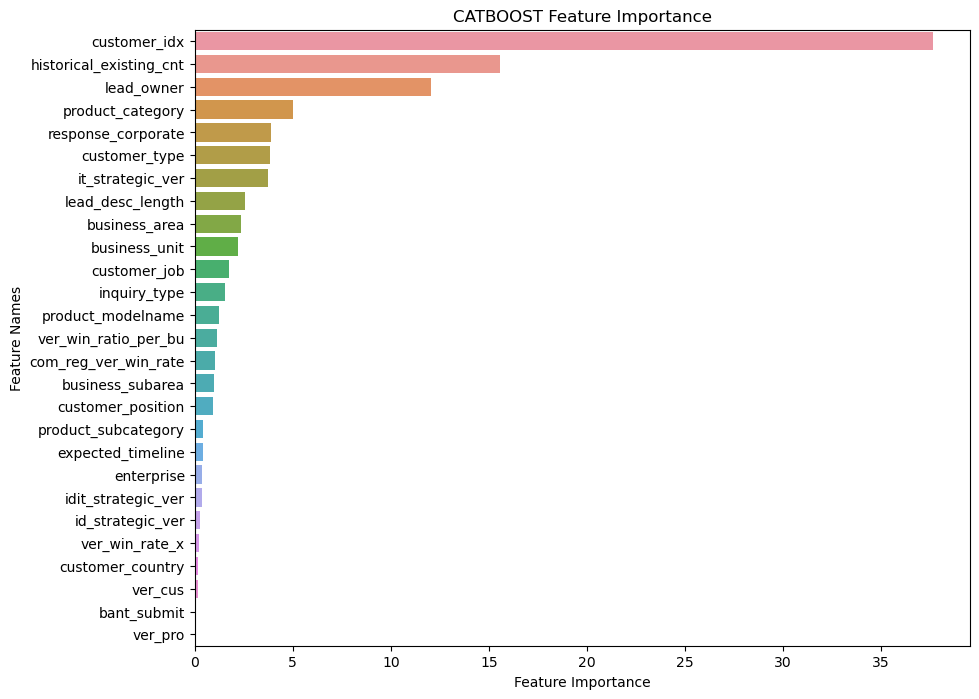

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_feature_importance(importance,names,model_type):
    
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,8))

    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')

plot_feature_importance(best_models[0].get_feature_importance(),df_test.drop(['is_converted','id'],axis=1).columns,'CATBOOST')